<a href="https://www.kaggle.com/code/maxbrehmer/covid-19-detection-cnn-chest-x-ray?scriptVersionId=217504867" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# <div style="padding:18px;color:white;margin:0;font-size:35px;text-align:center;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">Covid-19 Detection - Chest X-ray</div>

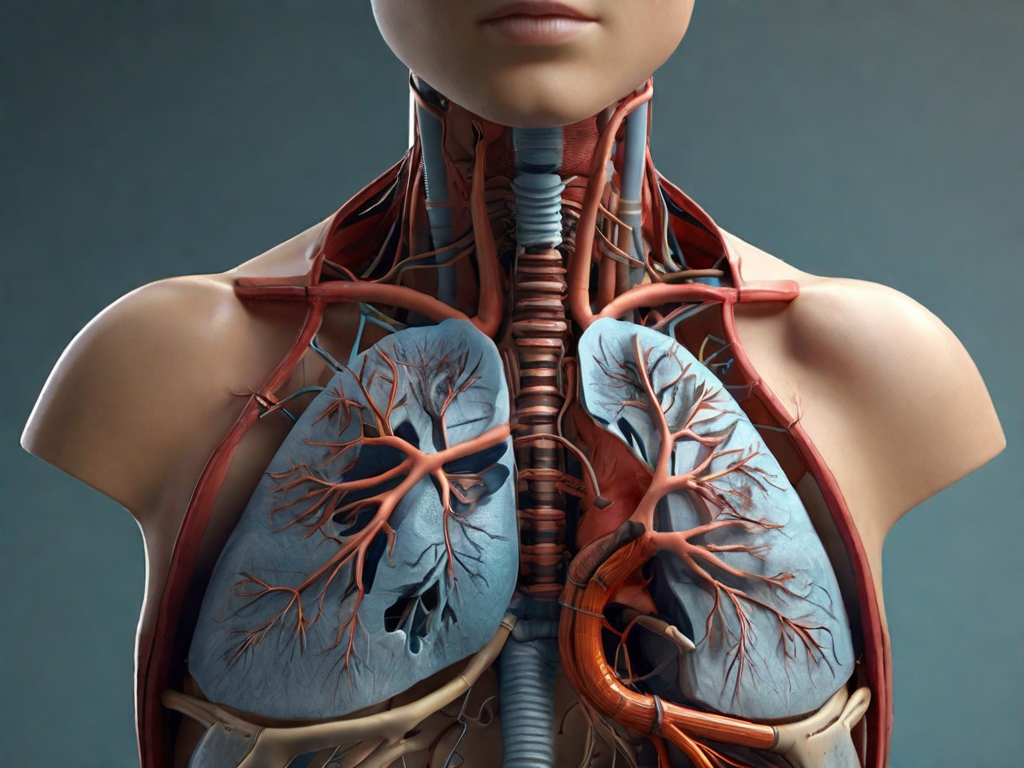


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">1 | Importing libraries | Image loading</div>

In [19]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import cv2

# Find directory paths for images
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_154.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_58.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_96.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_103.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_131.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_55.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_81.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_75.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_126.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_4.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_121.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_8.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_5.jpg
/kaggle/input/covid-19-vs-normal-che

In [20]:
# Assign directory path for images
train_data_dir = "/kaggle/input/covid-19-vs-normal-chest-x-rays/"
train_normal_dir = train_data_dir + "NORMAL/NORMAL/"
train_covid_dir = train_data_dir + "COVID/COVID/"


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">2 | Sample Images</div>

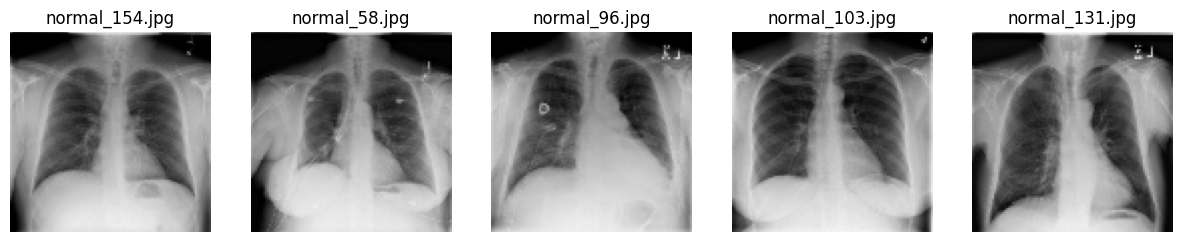

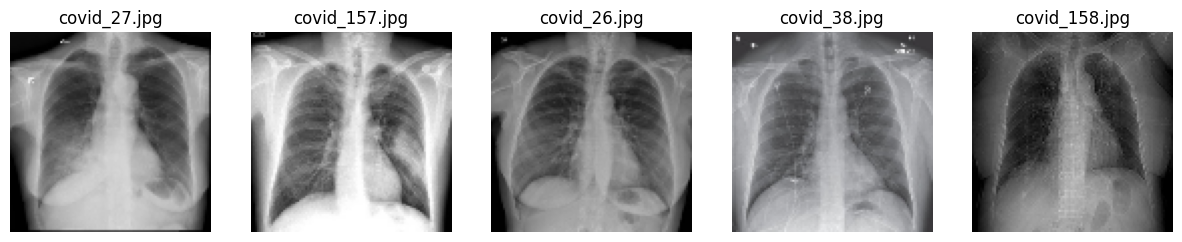

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_images(directory, num_images=5, image_size=(100, 100), title=''):
    plt.figure(figsize=(15, 3))
    plt.title(title)
    plt.axis('off')

    for i, image_name in enumerate(os.listdir(directory)[:num_images]):
        image_path = os.path.join(directory, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(image_name)

    plt.show()

display_images(train_normal_dir, title='NORMAL Images')
display_images(train_covid_dir, title='COVID Images')


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">3 | Image preprocessing</div>

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Rescaling
from tensorflow.data import AUTOTUNE

# Resize and scale images
img_height = 224
img_width = 224
batch_size = 32

# Load training and validation datasets
train_ds = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.25,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.25,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 324 files belonging to 2 classes.
Using 243 files for training.
Found 324 files belonging to 2 classes.
Using 81 files for validation.


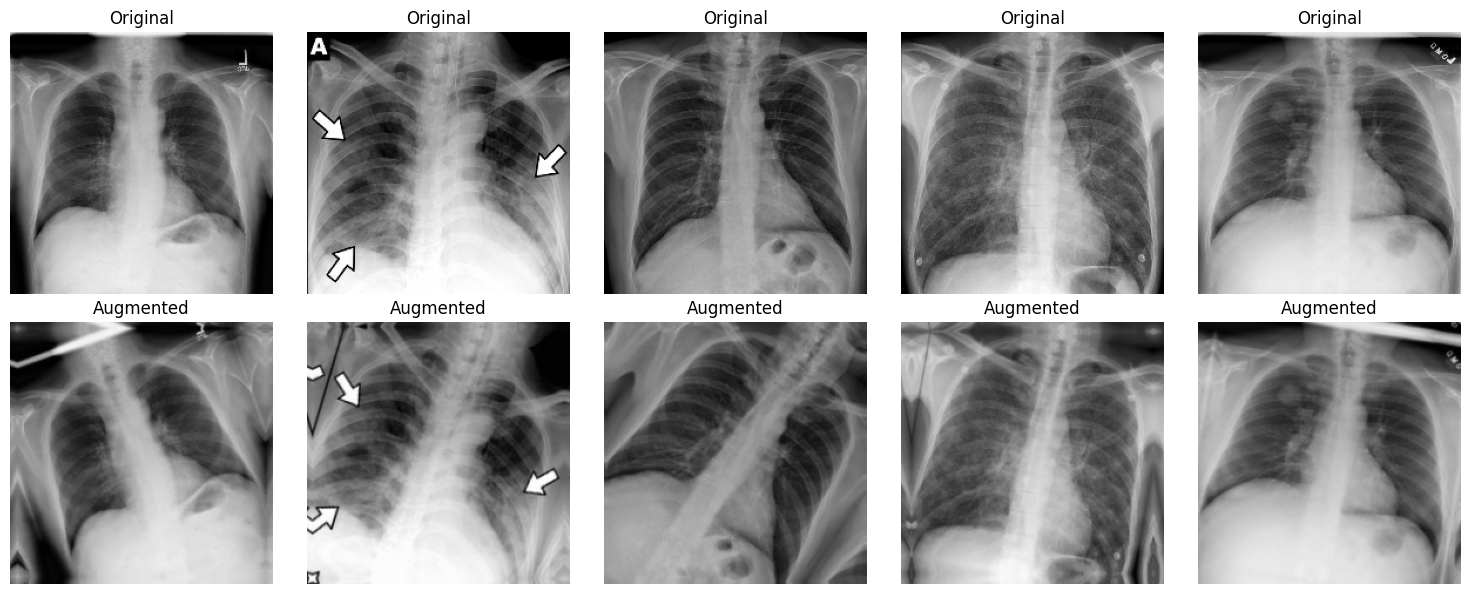

In [23]:
# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Function to display original and augmented images
def display_augmented_images(dataset, augmentation_model, num_images=5):
    for images, labels in dataset.take(1):  # Take one batch
        augmented_images = augmentation_model(images)  # Apply augmentation

        plt.figure(figsize=(15, 6))
        for i in range(num_images):
            # Display original image
            ax = plt.subplot(2, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
            plt.title("Original")

            # Display augmented image
            ax = plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(augmented_images[i].numpy().astype("uint8"))
            plt.axis("off")
            plt.title("Augmented")

        plt.tight_layout()
        plt.show()

# Display the images
display_augmented_images(train_ds, data_augmentation, num_images=5)

In [24]:
train_ds_cnn = train_ds
val_ds_cnn = val_ds

# Apply CNN-specific preprocessing
AUTOTUNE = tf.data.AUTOTUNE
train_ds_cnn = train_ds_cnn.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds_cnn = train_ds_cnn.prefetch(buffer_size=AUTOTUNE)
val_ds_cnn = val_ds_cnn.prefetch(buffer_size=AUTOTUNE)

# Normalize values
train_ds_cnn = train_ds_cnn.map(lambda x, y: (x / 255.0, y))
val_ds_cnn = val_ds_cnn.map(lambda x, y: (x / 255.0, y))

# Apply MobileNetV2-specific preprocessing
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

# Prefetch data to improve performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">4 | CNN</div>

In [30]:
model1 = models.Sequential()
model1.add(layers.Input(shape=(224, 224, 3)))
model1.add(data_augmentation)

model1.add(layers.Conv2D(32, (5, 5)))
model1.add(layers.ReLU())
model1.add(layers.MaxPooling2D((3, 3)))

model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.ReLU())
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(128, (3, 3)))
model1.add(layers.ReLU())
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(128, (3, 3)))
model1.add(layers.ReLU())
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Flatten())
model1.add(layers.Dense(128))
model1.add(layers.ReLU())
model1.add(layers.Dropout(0.2))

model1.add(layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 re_lu (ReLU)                (None, 220, 220, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 re_lu_1 (ReLU)              (None, 71, 71, 64)        0         
                                                      

In [31]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# Build the model
optimizer = Adam(learning_rate=0.000001)

def create_model():
    # Load MobileNetV2 pretrained on ImageNet
    base_model = MobileNetV2(input_shape=(224, 224, 3),
                             include_top=False,  # Exclude the top layer for custom classification
                             weights='imagenet')
    
    # Freeze the base model
    base_model.trainable = False
    #base_model.trainable = True
    
    # Freeze only the first 135 layers
    #for layer in base_model.layers[:135]:
        #layer.trainable = False
    #for layer in base_model.layers[135:]:
        #layer.trainable = True
    
    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Reset the model by clearing the backend and creating a new instance
backend.clear_session()
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2422081 (9.24 MB)
Trainable params: 238796

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the MobileNetV2 model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    callbacks=[early_stopping]
)

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the vanilla CNN model
history1 = model1.fit(
    train_ds_cnn,
    validation_data=val_ds_cnn,
    epochs=500, 
    callbacks=[early_stopping]
)

Epoch 1/500
8/8 [==============================] - 21s 279ms/step - loss: 0.7383 - accuracy: 0.5350 - val_loss: 0.8593 - val_accuracy: 0.5309
Epoch 2/500
8/8 [==============================] - 1s 148ms/step - loss: 0.7933 - accuracy: 0.4979 - val_loss: 0.8583 - val_accuracy: 0.5309
Epoch 3/500
8/8 [==============================] - 1s 147ms/step - loss: 0.7872 - accuracy: 0.5473 - val_loss: 0.8569 - val_accuracy: 0.5309
Epoch 4/500
8/8 [==============================] - 1s 147ms/step - loss: 0.7398 - accuracy: 0.5473 - val_loss: 0.8551 - val_accuracy: 0.5309
Epoch 5/500
8/8 [==============================] - 1s 144ms/step - loss: 0.7222 - accuracy: 0.5638 - val_loss: 0.8534 - val_accuracy: 0.5309
Epoch 6/500
8/8 [==============================] - 1s 148ms/step - loss: 0.7391 - accuracy: 0.5802 - val_loss: 0.8517 - val_accuracy: 0.5309
Epoch 7/500
8/8 [==============================] - 1s 146ms/step - loss: 0.7563 - accuracy: 0.5144 - val_loss: 0.8500 - val_accuracy: 0.5309
Epoch 8/500



# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">5 | Evaluation</div>

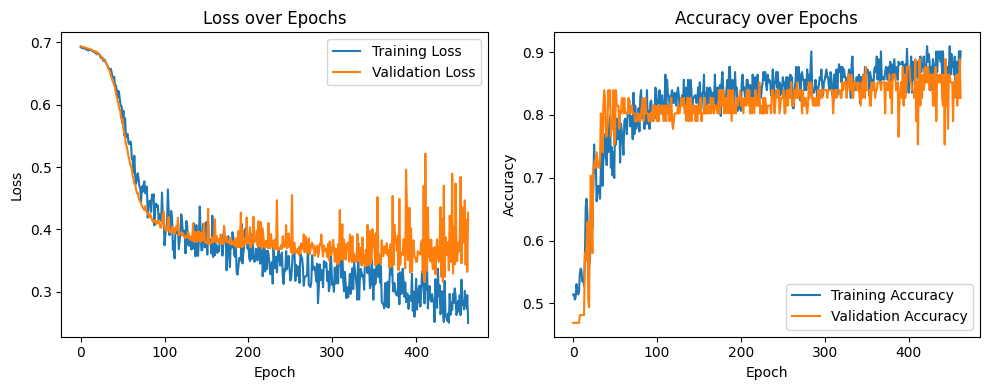

In [33]:
# VANILLA CNN MODEL

# Extract the loss and accuracy values for each epoch
train_loss_cnn = history1.history['loss']
val_loss_cnn = history1.history['val_loss']
train_acc_cnn = history1.history.get('accuracy', history1.history.get('acc', []))
val_acc_cnn = history1.history.get('val_accuracy', history1.history.get('val_acc', []))

# Plot loss curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_cnn, label='Training Loss')
plt.plot(val_loss_cnn, label='Validation Loss', linestyle='-')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc_cnn, label='Training Accuracy')
plt.plot(val_acc_cnn, label='Validation Accuracy', linestyle='-')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
#plt.savefig("ModelX.png")
plt.show()

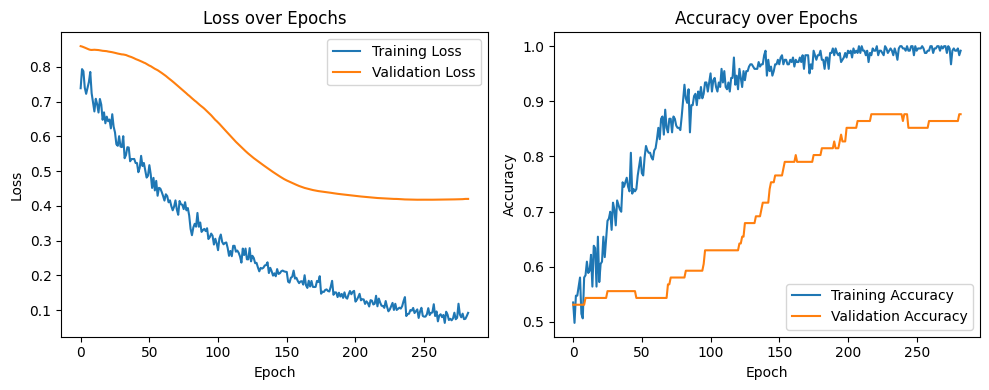

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

# TRANSFER LEARNING MODELS

# Extract the loss and accuracy values for each epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('accuracy', history.history.get('acc', []))
val_acc = history.history.get('val_accuracy', history.history.get('val_acc', []))

# Plot loss curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='-')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy', linestyle='-')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
#plt.savefig("ModelX.png")
plt.show()